# Recursos 

[LSTMS](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Unreasonably unRNNsonal](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[Best Practices: Deep Learning for NLP](http://ruder.io/deep-learning-nlp-best-practices/index.html)

In [0]:
%matplotlib inline

import keras
import numpy as np


Using TensorFlow backend.


# Prerequisitos

Para el día de hoy asumiremos que hemos visto Deep Learning. Haremos un breve repaso, pero la idea es centrarse en el uso de las distintas arquitecturas dentro de Deep Learning.

# Brevísimo repaso

Deep Learning se convierte en viable por dos grandes factores, el uso de GPUs, y la aparición del "Big Data". Son modelos de Machine Learning, pero que además aprenden "features". Es decir, hace 5-10 años se gastaba muchos esfuerzos en conseguir buenas features para cada tipo de problema, hoy en día, se gastan muchos esfuerzos en comprar GPUs y conseguir datos. 

Deep Learning ha tenido un immenso desarrollo en Computer Vision, en NLP el progreso es menor. El progreso en NLP empieza a crecer con el desarrollo de los word embeddings, que ahora son parte obligada en cualquier pipeline de NLP que use deep learning. En la anterior clase creamos nuestros propios word embeddings, ahora es momento de añadirlos dentro del pipeline.

Como es bien sabido, entrenamos nuestros modelos con gran cantidad de datos, no siempre bien curados. [Aquí](https://retina.elpais.com/retina/2017/05/12/tendencias/1494612619_910023.html) teneis un artículo que salió el año pasado en El Pais, en que se denunciaba el bias que conlleva entrenar ciertos modelos así. De hecho, me costaba creermelo, así que decidí comprobarlo, y la verdad es que ... los resultados me sorprendieron... por ser ciertos. En visión por ordenador, este tipo de problemas no nos lo encontramos, podemos encontrarnos otro tipo de problemas, pero este no. Este tipo de problemas son generados cuando usamos unsupervised learning para entrenar modelos. 

Dicho esto, si para imagen hemos usado redes convolucionales, y quizas ¿recurrentes? para texto usaremos las mismas. A medida que las vayamos usando iremos explicando un poquito de rol, y que podemos esperar de ellas, y la motivación en su uso.

![BILSTM](https://pbs.twimg.com/media/C8f9PdkVoAACcot.jpg "BILSTM")

## Tipos de red que usaremos
1. DNN
2. CNN
3. RNN

## Arquitecturas y Operaciones avanzadas (si hay tiempo)
1. Seq2Seq
2. Attention

## Pipeline para redes neuronales

Como modifica nuestro pipeline Deep Learning? Más bien poco. Seguiremos generalmente generando un vocabulario de nuestro test de entrenamientos. En algunos casos usaremos tokens especiales como '_UNK_', _PAD_, _SOS_ o _EOS_, nada que no hayamos visto antes. Usaremos las mismas técnicas de mapeo de palabra a índice como ya hemos hecho con anterioridad y poco más. Donde si nos cambia un poco es en el tema del diseño del modelo, donde hay que tener en cuenta que hay que añadir word embeddings en el proceso. De todas formas como veréis, es bastante fácil recordar como, porque siempre funciona exactamente igual. 

En resumidas cuentas:

1. Data preprocess.
2. Word Embeddings
2. Define Model
3. ???? (fit)
4. Profit

## Diseño normal de una red

![Typical Design](https://i.imgur.com/ijJ0M5G.png "Typical Design")

Fijaros una cosa que es muy importante aquí, aunque lo he diferenciado. Los embeddings son una parte ENTRENABLE de la red. Es decir, no es que generemos unos embeddings, y eso pasen a ser el input de nuestros modelos, sino que son parte ENTRENABLE. Es verdad, que como cualquier capa de una red, sus pesos pueden ser congelados, pero es una opción. 

### Tips cuando metemos word embeddings

* Suele ser buena idea usar pre-trained word embeddings. Aquí tenéis [GloVe](https://nlp.stanford.edu/projects/glove/), [word2vec](https://code.google.com/archive/p/word2vec/) y [fasttext](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

* Algo que mucha gente se olvida cuando usa pretrained vectors, es que los usa todos. Tenemos que plantearnos que vocabulario usara nuestra aplicación. Si tenemos un train set muy claro, lo ideal es solo usar una matriz de *V x dim*, donde V es el vocabulario del train set. Esto se hace porque en muchas aplicaciones de hoy en día, sobretodo si vamos a trabajar con datos de usuarios, con input libre, es muy probable que empiezen a entrar palabras que no hemos visto nunca en el entreno, por lo tanto es mejor evaluar en codiciones "reales" usando el token de *UNK* cuando no hemos visto el token/palabra del input.

* No entraremos en tips para mejorar la performance en el entreno, pero si que es buena idea cuando usemos por ejemplo CNNs, que hagamos un pequeno estudio previo de la longitud máxima de la secuencia, y la media, para poder padear acorde.

### Que pasa cuando hacemos fine-tunning de word embeddings?

Imaginad que tenemos, como el caso de los mencionades anteriormente unos word embeddings "genéricos", entrenados sólo por tener los word embeddings. Luego los usamos para una tárea de clasificación. Son reaprovechables estos word-embeddings re-entrenados?


## Ejemplo de clasificación clásico

### Imports/Preprocess

In [0]:
!pip install spacy
!python -m spacy download en_core_web_sm

    100% |████████████████████████████████| 37.4MB 24.8MB/s 

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [0]:
import spacy

import pickle
import json
import os
import csv

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import io


from random import sample

from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')



In [0]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner', 'textcat'])

In [0]:
def split_train_val_test(dataset, split=0.2):

    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1337) #l33t seed
    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}
    return splits

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test (3).csv
User uploaded file "test.csv" with length 21775285 bytes


In [0]:
labels = ['Company',
            'EducationalInstitution',
            'Artist',
            'Athlete',
            'OfficeHolder', 
            'MeanOfTransportation',
            'Building',
            'NaturalPlace',
            'Village',
            'Animal',
            'Plant',
            'Album',
            'Film',
            'WrittenWork'
         ]


In [0]:
df = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')), names=['class', 'title', 'content'])

# col_list = ['text', 'message']

# df = df[col_list]

# df = df.drop(columns=drop_col, axis=1)
df

,class,title,content
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic bever...
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longt...
2,1,Henkel,Henkel AG & Company KGaA operates worldwide w...
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC ...
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the Rag...
5,1,Pošte Srpske,Pošte Srpske is one of three companies respon...
6,1,Open Kernel Labs,Open Kernel Labs (OK Labs) is a privately own...
7,1,Skye Bank,Skye Bank Plc. commonly known as Skye Bank is...
8,1,CNet Technology,CNet Technology is a Taiwanese company that m...
9,1,188BET,188BET is an online sportsbook provider. 188B...


In [0]:
dataset = []
for row in df.iterrows():
    ix, data = row
    dataset.append((data[2], data[0]))

In [0]:
from collections import Counter

In [0]:
tokens = []
tokenized = []
for x, y in dataset:
    x_t = nlp(x)
    toks = [t.text for t in x_t]
    tokens+= toks
    tokenized.append((toks, y))
    
vocab_counter = Counter(tokens)
vocab = set(tokens)
print('Num de features a usar: ', len(vocab))  
print(len(tokenized))    

Num de features a usar:  203596
70000


In [0]:
maxlen = max([len(x) for x, _ in tokenized])
maxlen

547

In [0]:
lens = [len(x) for x, _ in tokenized]
median = np.median(np.array(lens))
mean = np.mean(np.array(lens))
maxlen = int(median)*2
print(median, mean, maxlen)

53.0 53.20654285714286 106


In [0]:
tokenized_filtered = [(x, y) for x, y in tokenized if len(x) < maxlen]
len(tokenized_filtered)

69782

In [0]:
# Construir el vocabulario como siempre
w2id = {k:i for i, k in enumerate(vocab)}
w2id['<UNK>'] = len(w2id)

### Padding + Input preparation

In [0]:
l2id = {label:i for i, label in enumerate(labels)}

In [0]:
# Preparar Input. Padding. Conversión a input
# maxlen = min(maxlen, 50)
input_ready = []
for x, y in tokenized_filtered:
    sentence = np.zeros((maxlen))
    label = np.zeros((len(labels)))
    label[int(y)-1] = 1
    for i, t in enumerate(x):
        sentence[i] = w2id[t] if t in vocab_counter and vocab_counter[t]>=5 else w2id['<UNK>']
    input_ready.append((sentence,label))

In [0]:
input_ready[0][0].shape

(106,)

In [0]:
splits = split_train_val_test(input_ready)
print(splits['train'][0].shape)
print(splits['train'][1].shape)
splits['train'][1]

(55825, 106)
(55825, 14)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Simple Models

## No Embeddings

### As a sequence of tokens

### Simple Model Fit

### Simple Model Test

### Ahora con unigrams

## Ahora con embeddings

Que ha pasado conn los shapes? Son correctos? Es correcta la shape del output?

# Deep Averaging Networks

Este paper del 2015 ([DAN](http://www.cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf)), presentan un modelo super simple, que da muy buenos resultados en text classification. 

Esta es la arquitectura.

![](https://i.imgur.com/Ry4isGW.jpg =500x)

Como veis es muy muy simple, cogemos emeddings, hacemos un average de ellos, y lo pasamos por un par de capas. Vamos a implementarlo y ver que pasa.

Esta estructura tan simple, actualmente se usa dentro de sistemas complicadíssimos, como Alexa.

In [0]:
from keras.layers import Input, Average, average, Lambda
from keras.models import Model

from keras import backend as K

#### Creación de Lambda Custom

# Convolutional Neural Networks para Texto

## Refresco de la arquitectura típica.

![](https://adeshpande3.github.io/assets/Cover.png)

Tenemos un input, normalmente en imágenes podemos pasarlo en (3, HEIGHT, WIDTH), por ejemplo, esto lo pasamos por una capa convolucional, que no es más que multiplicar trozos de la imagen por unos filtros, que no son más que una matriz de pesos que queremos aprender, hacer el pooling, que es quedarn-nos con las features más importantes, y así ir repitiendo. El resultado de estas convoluciones+poolings, es lo que anteriormente era *feature engineering*. El vector de feature resultantes se pasa por unas fully connected (Dense) layers, y al final una predicción.

[Stanford CNN](http://cs231n.github.io/convolutional-networks/) Aquí tenéis un link, que seguro que ya os han pasado, que explica perfectamente el funcionamiento de las redes convolucionales.

## Para texto

La idea de redes convolucionales para texto fue introducida en 2014 es este [paper](http://www.aclweb.org/anthology/D14-1181) por Yoon Kim. Es un magnífico paper, que de la nada, consiguió SoTA resultados, con una estructura, algo más compleja que la de los DANs, peró dejo unas ideas muy interesantes. Además el paper esta muy bien porque vislumbra ya que pasa cuando usamos pre-trained word embeddings versus si usamos aleatorios al iniciar la red y alguna otra comparación. Bastante recomendable la lectura, aunque sea por encima.

Os dejo aquí la arquitectura que implementaremos.

![CNN](https://datawarrior.files.wordpress.com/2016/10/cnn.png?w=640 "CNN Simple")

Fijaros en una cosa muy interesante de la imagen. Os recuerda a algo los filtros? n-grams? Pues si. Las redes convolucionales para texto, "aprenden" n-grams. Hemos vuelto a la segunda clase. El paper además introduce un concepto, o un rehuso del concepto que visteis en deep learning, en visión por ordenador, que es el de channel. Aquí en lugar de RGB, podríamos usar GloVe, SkipGrams, y FastText vectors. De todas formas veremos que los modelos con poca complejidad ya dan bastantes buenos resultados.



# Recurrent Neural Network para texto

Hasta ahora, hemos seguido trabajando basandonos en una premisa, que no es del todo cierta, que es que cada variable de nuestro input es independiente. Las capas nos sirven para buscar formas de combinarlas pero en el momento del input, cada *x* es independiente. Y realmente, como ya hemos comentado anteriormente, y como visteis cuando hicimos Language Modeling, cada palabra realmente depende del pasado. De hecho, cada palabra depende del pasado y del futuro, pero de momento, quedemonos en que cada feature depende del pasado, no solo del pasado más immediato, sino de todo el pasado.

Como modelamos esto? De bien seguro que en Deep Learning ya habeis visto la arquitectura, lo modelamos con Recurrent Neural Networks. De hecho, para deep, las redes más profundas son las recurrentes. Pero en lugar de ser profundas en "capas que nosotros podamos stackear" son muy profundas en el eje del tiempo.

No implementaremos estas redes desde 0, lo hicisteis en Deep Learning? En cualquier caso, aquí dejo un [tutorial](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) magnífico.

![RNN](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg "RNN Simple")

Equaciones de una RNN

![](http://s0.wp.com/latex.php?latex=%5Cbegin%7Baligned%7D++s_t+%26%3D+%5Ctanh%28Ux_t+%2B+Ws_%7Bt-1%7D%29+%5C%5C++%5Chat%7By%7D_t+%26%3D+%5Cmathrm%7Bsoftmax%7D%28Vs_t%29++%5Cend%7Baligned%7D++&bg=ffffff&fg=000&s=0)

Haremos un pequeño ejercico para que entendáis lo que es cada cosa.

*   U: Matriz input-hidden
*   W:  Matriz hidden-hidden
*   V: Matriz hidden-output
*   t: tiempo (time-step, input en el momento t...)
*   st: hidden state
*   xt: input en el step t. 1-hot vector

Tenemos un vocabulario de 50, por decir algo, y nuestro problema es un Language Modeling, con lo que el espacio de outputs será 50 igual. Si fuera un problema de clasificación pues los labels que tengamos.


In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference


De hecho lo que hemos hecho aquí arriba practicamente sería el forward pass implementado en numpy.

Vamos a ver la implementación en Keras, y a entrenar una para un problema de clasificación

In [0]:
from keras.layers import LSTM, SimpleRNN

In [0]:
rnn_type = SimpleRNN(100)

# LSTM

Las LSTMs son quizás de mis preferidas estructuras preferidas, y quizás hasta la fecha uno de los componentes más relevantes en Deep Learning.

Se que habéis visto ya redes recurrentes, y que os han explicado algo de las LSTMs. Aquí nos pararemos un segundo, en explicaros de dónde vienen las LSTMs, y porque no nos es suficiente con las recurrents. Imagino que este blog [post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) ya os lo han recomendado, de hecho si la imagen os suena, la he sacado de ahi.

![LSTM](http://www.stratio.com/wp-content/uploads/2017/10/6-1.jpg =600x)

### Que pasa con las RNNs?

Si miráis el dibujo de arriba, el de las Vanilla RNNs, y os acordáis que he dicho que son las redes más profundas, veréis que no os he mentido. Las redes recurrentes de tan profundas que son, tienen ciertos problemas, que ahora són muy obvios, no tanto hace un tiempo. El principal problema se llama Vanishing Gradient, descubierto por Sepp Hochreiter en 1991 (hace casi 30 años). 

#### Vanishing Gradient

Si os fijais, las matricecs W, U, V, son compartidas en el tiempo, pero W y U, además de alguna forma u otra se ven en cada forward pass. Que dices?

![](https://i.imgur.com/U4PU3ao.jpg =400x)

Cuando quereis calcular algo en el step t=5, teneis que tener calculado lo que pasaba en el t=4, pero para el t=4 necesitáis el t=3 y así hasta el 0.

Esto esta muy bonito, porque conseguimos que cualquier punto de la secuencia pueda afectar al output en t=actual, pero tiene el problema que W es compartida en todos los timesteps (U igual). Al ser compartidos los valores de W, los valores que modifican W, es decir los gradientes, tambien hay que calcularlos a cada momento. Es decir, que cuando calculemos estos valores en t=5, los tendremos que pasar a 4, 3... y hasta 0.
Esto provoca, que si estamos trabajando con valores muy peques, al final, estos valores tendiran a 0, hasta convertir-se en 0s o NaNs, o si por lo que sea, estos valores son muy grandes, los gradientes se dispararan, y subiran por las nubes. La consecuencia de todo esto, es que estas redes, aunque potencialmente pueden aprender largas dependencias, la verdad es que no son capaces de ello.

![](https://i.imgur.com/YDiQB8d.png)

Vanilla RNN vs LSTM

![](https://i.imgur.com/Eb5aATV.png)

Ver que pasa con W

### Vale, pero cuentame las LSTMs

En 1997, hace 21 años, en un laboratorio europeo, Sepp Hochreiter y Juergen Schmidhuber sacan estas LSTMs, que ellos describen como el trabajo "obvio" que deriva del descubrimiento del "Vanishing Gradient". Y si, dijo obvio. Bien, las LSTMs, basicamente son 4 capas, dentro de una "super-capa". 

Estas LSTMs, debido a su estructura interna, son capaces de guardar información entre dependencias más largas. No entraremos en el detalle de como lo hacen, pero para que veias como funciona el forward pass, implementaremos las ecuaciones de una celda LSTM. [Blog post](https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html) explicando el porque las LSTMs no tienen el mismo problema que las vanilla RNN.

![](https://i.imgur.com/h4tZrh0.jpg)

Como podéis ver, una celda LSTM es bastante más complicada que la de una recurrente normal, y esto tiene un coste computacional associado, a más matrices, más cuesta entrenar, y más tiempo (por pequeno que sea), cuesta predecir. 

Las celdas LSTMs tiene 3 pasos, que queremos olvidar, que queremos aprender, y que queremos mostrar, en este orden. Es decir, nuestras matrices gestionan, que olbidamos del paso anterior, que creemos que es útil del input actual, y que queremos mostrar en el input actual. Vamos a ver sus ecuaciones, y luego a usar una en una red con keras.




In [0]:
# introducir ecuaciones como en Vanilla RNN
import numpy as np

In [0]:
# cosas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

![](https://i.imgur.com/jbAEXGd.jpg =500x)

El bias del output no es de t sino de o.

![](https://i.imgur.com/jbAEXGd.jpg =500x)

Es b_o aquí.


### Implementación en Keras

In [0]:
from keras.layers import CuDNNLSTM

In [0]:
rnn_type = CuDNNLSTM(100)

## Ampliaciones de la LSTM

Para finalizar, con las las redes recurrentes, podéis hacer exactamente igual que con las convolucionales. Podeis stackear capas. Como quedaría entonces?

![](https://discuss.pytorch.org/uploads/default/optimized/2X/f/fb98eb0d16b722e019db59f97825aa529cb6bc08_1_685x499.png =500x)

Es decir, en la primera capa, el input seria exactamente igual, pero el input de las LSTMs en las siguientes capas sería el output de la capa anterior, exactamente igual que cualquier otra arquitectura.

Al principio he puesto la imagen sobre BiLSTM. Una BiLSTM es una arquitectura algo especial, no es una LSTM con 2 capas...unicamente.

Os acordais que a veces, cuando hablo de que cuando hablamos de cómo hablamos  o escribimos, que en realidad no estamos construyendo palabra a palabra, sino que nuestro cerebro tiene una idea de principio a fin, y en verdad vamos rellenando, de atrás hacia adelante, y vice-versa. Pues las BiLSTMs, sse llaman así, porque son Bidireccionales. Tienen 2 capas, pero el input es la propia x, no como cuando stackeamos capas.

![](https://cdn-images-1.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

Si os fijais en el sentido de las flechas, veréis que unas van hacia un lado, y las otras hacia el otro, es decir, de principio a fin, y de fin a principio. Esta arquitectura, actualmente es el standard para muchísimas tareas! 

Y, en keras, es facilísimo de implementar.

# Results Visualization

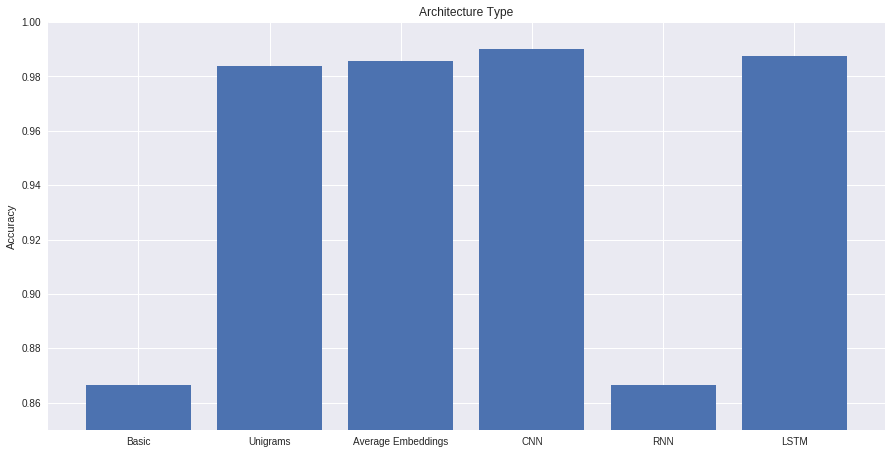

In [0]:
plt.rcParams['figure.figsize'] = [15, 7.5]
fig, ax = plt.subplots()
ind = np.arange(1, 7)

values = [x for x, _ in scores]
labels = [y for _, y in scores]

plt.bar(ind, values)
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.set_ylim([0.85, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Architecture Type')